In [1]:
%%capture
import sys
!pip install tensorflow-addons
!pip install yfinance
!git clone https://github.com/ICascha/QuantGANs-replication.git
!unzip QuantGANs-replication/trained_models/trained_generator_dow -d QuantGANs-replication/trained_models
sys.path.append('/content/QuantGANs-replication/')

In [2]:
from backend.preprocessing import *
from backend.metrics import *
from backend.tcn import make_TCN
from backend.clustering import *

import pandas as pd
import pandas_datareader as pdr
import yfinance as yf
yf.pdr_override()
import matplotlib.pyplot as plt
import numpy as np

from google.colab import files
from time import sleep

In [3]:
df_wgt = pd.read_csv('/content/QuantGANs-replication/data/dow_weight.csv')
wgt = df_wgt['weight'].to_numpy()
df_wgt.head()

,ticker,weight
0,GS,6.74
1,MMM,5.88
2,IBM,5.56
3,BA,5.43
4,HD,5.15


In [4]:
# might need to run this a couple of times
df = pdr.get_data_yahoo(df_wgt['ticker'], start="2014-1-1", end="2018-12-31")['Adj Close']
log_returns = np.log(df/df.shift(1))[1:].to_numpy()

df.head()

Symbols,GS,MMM,IBM,BA,HD,MCD,UNH,TRV,DIS,AAPL,JNJ,RTX,CVX,PG,XOM,V,AXP,WMT,CAT,NKE,JPM,DD,MSFT,MRK,VZ,KO,INTC,PFE,GE,CSCO
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2014-01-02,156.999069,111.851845,137.696884,116.807953,69.256310,78.247192,66.241653,74.947701,70.192497,17.568451,74.239182,59.149864,90.061829,64.274483,71.763840,52.488445,79.889244,66.277122,71.923302,36.000107,47.637249,51.077164,31.983477,37.501186,35.055759,31.921825,20.957815,21.943314,22.299896,17.479795
2014-01-03,158.117401,112.110909,138.520721,117.619873,69.146507,78.352707,66.712471,74.805077,70.045273,17.182550,74.907944,59.365467,90.214172,64.202667,71.591171,52.524067,80.148262,66.058739,71.883308,35.903465,48.005512,50.844311,31.768301,37.683060,34.640827,31.764788,20.949682,21.986536,22.283680,17.463903
2014-01-06,159.200211,111.446899,138.045746,118.295074,68.479454,77.792671,65.948502,74.603714,69.778374,17.276245,75.299393,59.307617,89.974770,64.354309,71.699089,52.208202,80.112511,65.689186,70.938919,35.627399,48.283752,50.751163,31.096956,37.690628,34.833996,31.615639,20.689642,22.008146,22.105280,17.487747
2014-01-07,158.241592,111.463104,140.799240,120.089874,68.817207,78.222855,67.964981,74.167450,70.256927,17.152693,76.897903,59.686214,90.736534,64.976753,72.713493,52.607197,79.808891,65.890778,71.171036,35.654999,47.727261,50.192314,31.337952,37.971001,35.270397,31.709852,20.795280,22.145023,22.129606,17.726107
2014-01-08,158.374741,110.637184,139.507858,120.354836,69.180321,77.435593,67.174385,73.479477,69.226189,17.261324,76.791862,59.759808,89.445168,64.035057,72.476074,52.775818,80.059601,65.370026,71.339088,35.470947,48.177376,50.250511,30.778502,37.728523,35.075134,31.356558,20.665264,22.296303,22.064739,17.710211


In [5]:
s1 = StandardScaler()

# receptive field size
rfs = 127

# pre-processing pipeline, note the removal of Gaussianize operation,
# this operation has to be individually applied to all 30 return series,
# due to disrepenencies in mean and variance across return series, 
# complicating the pre-processing reversal process.
log_returns_preprocessed = s1.fit_transform(log_returns)
log_returns_rolled = rolling_window(log_returns_preprocessed, rfs)

In [6]:
dilations = 2**(np.arange(6))
n_filters = 80

discriminator = make_TCN(dilations, n_filters, 0, False, False, False, [1, rfs, 1])
generator = make_TCN(dilations, n_filters, 0, True, False, False, [1, None, 3])

In [7]:
from tensorflow.keras.utils import Progbar
from tensorflow.random import normal

class multiDataGAN(GAN):
    def train(self, data, batch_size, n_batches, additional_d_steps):
        progress = Progbar(n_batches)

        for n_batch in range(n_batches):

            batch_idx_class = np.random.choice(np.arange(data.shape[3]), p=wgt/100, size=batch_size)
            batch_idx_time = np.random.choice(np.arange(data.shape[0]), size=batch_size, replace=(batch_size > data.shape[0]))
            batch = data[batch_idx_time, ..., batch_idx_class]

            self.train_step(batch, batch_size, additional_d_steps)

            self.train_hook(n_batch)

            progress.update(n_batch + 1)

    def train_hook(self, n_batch):
        if (n_batch + 1) % 500 == 0:
            y = self.generator(self.fixed_noise).numpy().squeeze()
            scores = []
            scores.append(np.linalg.norm(self.acf_real - acf(y.T, 250).mean(axis=1)))
            scores.append(np.linalg.norm(self.abs_acf_real - acf(y.T**2, 250).mean(axis=1)))
            scores.append(np.linalg.norm(self.le_real - acf(y.T, 250, le=True).mean(axis=1)))
            print("\nacf: {:.4f}, acf_abs: {:.4f}, le: {:.4f}".format(*scores))
        
gan = multiDataGAN(discriminator, generator, lr_d=3e-4, lr_g=1e-4)

gan.acf_real = np.average(acf(log_returns_preprocessed, 250), axis=1, weights=wgt)
gan.abs_acf_real = np.average(acf(log_returns_preprocessed**2, 250), axis=1, weights=wgt)
gan.le_real = np.average(acf(log_returns_preprocessed, 250, le=True), axis=1, weights=wgt)

gan.fixed_noise = normal([128, 1, 4000 + rfs - 1, 3])

In [8]:
data = np.expand_dims(np.moveaxis(log_returns_rolled, 0, 1), 1)
batch_size = 512
n_batches = 1000
additional_d_steps = 0

gan.train(data, batch_size, n_batches, additional_d_steps)

 499/1000 [=============>................] - ETA: 4:33
acf: 0.2263, acf_abs: 0.1933, le: 0.1751
 999/1000 [============================>.] - ETA: 0s
acf: 0.2158, acf_abs: 0.1715, le: 0.1914
1000/1000 [==============================] - 576s 562ms/step


In [9]:
generator.save('trained_generator_dow')

INFO:tensorflow:Assets written to: /content/gdrive/My Drive/THESIS/trained_generator_dow_jones/assets


In [10]:
!zip -r trained_generator_dow.zip trained_generator_dow/ 

Archive:  trained_generator_dow.zip
   creating: QuantGANs-replication/trained_generator_dow/assets/
  inflating: QuantGANs-replication/trained_generator_dow/saved_model.pb  
   creating: QuantGANs-replication/trained_generator_dow/variables/
  inflating: QuantGANs-replication/trained_generator_dow/variables/variables.data-00000-of-00001  
  inflating: QuantGANs-replication/trained_generator_dow/variables/variables.index  


In [11]:
sleep(20)
files.download('trained_generator_dow')

In [12]:
noise = normal([1000, 1, len(log_returns_preprocessed) + rfs - 1, 3])

# fit a StandardScaler on a dow jones weighted average to inverse transform
s2 = StandardScaler().fit(np.expand_dims(np.average(log_returns, weights=wgt, axis=1), 1))

y = generator(noise).numpy().squeeze()

y = (y - y.mean(axis=0))/y.std(axis=0)
y = s2.inverse_transform(y)

# some basic filtering, GAN has the tendency to produce extreme returns, caused by
# a tendency of the generator to produce heavier than normal tails, which is exercerbated
# by the lambert W transform. We filter out returns with more than twice the extremas of the
# original distribution.
y = y[(y.max(axis=1) <= 2 * log_returns.max()) & (y.min(axis=1) >= 2 * log_returns.min())]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

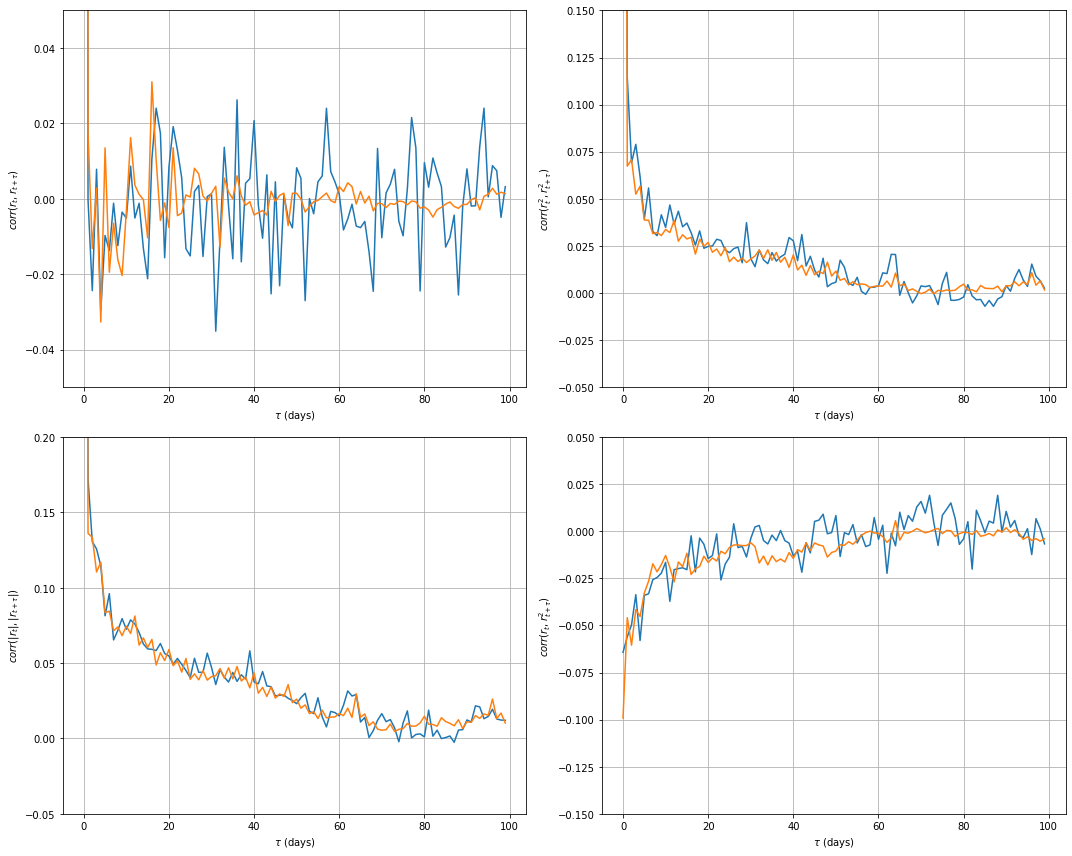

In [13]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 12))

avg_log_return = np.expand_dims(np.average(log_returns, weights=wgt, axis=1), axis=-1)

axs[0, 0].plot(np.average(acf(log_returns, 100), weights=wgt, axis=1))
axs[0, 0].plot(acf(y.T, 100).mean(axis=1))
axs[0, 0].set_ylim(-0.05, 0.05)
axs[0, 0].set_ylabel('$corr(r_t, r_{t+\\tau})$')

axs[0, 1].plot(np.average(acf(log_returns**2, 100), weights=wgt, axis=1))
axs[0, 1].set_ylim(-0.05, 0.15)
axs[0, 1].set_ylabel('$corr(r_t^2, r_{t+\\tau}^2)$')
axs[0, 1].plot(acf(y.T**2, 100).mean(axis=1))

axs[1, 0].plot(np.average(acf(abs(log_returns), 100), weights=wgt, axis=1))
axs[1, 0].plot(acf(abs(y.T), 100, le=False).mean(axis=1))
axs[1, 0].set_ylim(-0.05, 0.2)
axs[1, 0].set_ylabel('$corr(|r_t|, |r_{t+\\tau}|)$')

axs[1, 1].plot(np.average(acf(log_returns, 100, le=True), weights=wgt, axis=1))
axs[1, 1].plot(acf(y.T, 100, le=True).mean(axis=1))
axs[1, 1].set_ylim(-0.15, 0.05)
axs[1, 1].set_ylabel('$corr(r_t, r_{t+\\tau}^2)$')

for ax in axs.ravel(): ax.grid(True)
plt.setp(axs, xlabel='$\\tau$ (days)')
plt.tight_layout()

plt.savefig('dow_dependency.png', dpi=300)
files.download("dow_dependency.png");

In [14]:
real_samples, synth_samples, real_bins, synth_bins, total_freq, kmeans = clustering(log_returns, y.T, 16, 30)

In [15]:
import matplotlib.pyplot as plt
import numpy as np
from backend.preprocessing import rolling_window
from sklearn.cluster import KMeans


def clustering(real_returns, synth_returns, window_length, n_clusters, random_state=0):
    """cluster real and synthetic returns. Synthetic returns are used to determine cluster
    

    Args:
        real_returns (2d-array): real returns in shape (timesteps, 1)
        synth_returns (2d-array): synthetic returns in shape (timesteps, samples)
        window_length (int): length of moving window, skips across 2*window_length when moving
        n_clusters (int): number of clusters
        random_state (int, optional): seed of kmeans RNG. Defaults to 0.

    Returns:
        tuple: tuple of real and synthetic samples, their corresponding bins, 
        array of total frequency of both real and synthetic returns and a fitted kmeans object
    """    

    real_samples = rolling_window(real_returns, window_length).T.reshape((-1, window_length))
    # We cluster based on synth samples, so we skip ahead twice the window length
    # to avoid interdependencies of windows
    synth_samples = rolling_window(synth_returns, window_length)[:, ::window_length*2].T.reshape((-1, window_length))
    
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state)
    kmeans.fit(synth_samples)

    real_bins = kmeans.predict(real_samples)
    synth_bins = kmeans.predict(synth_samples)

    real_freq = np.bincount(real_bins)
    synth_freq = np.bincount(synth_bins)

    total_freq = np.stack([real_freq, synth_freq])
    total_freq = total_freq / total_freq.sum(axis=1, keepdims=True)

    return real_samples, synth_samples, real_bins, synth_bins, total_freq.T, kmeans

def plot_clustering(synth_samples, synth_bins, alpha, bins, figsize):
    """Plut 9 clusters on a 3x3 grid
    Args:
        synth_samples (2d-array): synthetic windows used (non-overlapping)
        synth_bins (1d-array): array of bins
        alpha (float): transparancy of plotted returns, 1 = opaque, 0 = invisible
        bins (int): bins considered in plotting
        figsize(tuple): tuple of (length, height) of figure
    Returns:
        tuple: tuple of matplotlib.pyplot figure and axes object
    """    
    fig, axs = plt.subplots(figsize=figsize, nrows=3, ncols=3, sharex=True, sharey=True)

    i = 0
    j = 0
    for bin in bins:
        axs[i, j].plot(np.moveaxis(synth_samples[synth_bins == bin], 0, -1), color='orange', alpha=alpha)
        axs[i, j].set_title('# paths: {}'.format(int((synth_bins == bin).sum())))
        axs[i, j].grid(axis='y', which='major')

        j += 1
        j = j % 3
        if j == 0:
            i += 1

    plt.setp(axs[-1, :], xlabel='time (days)')
    plt.setp(axs[:, 0], ylabel='log return')

    return fig, axs

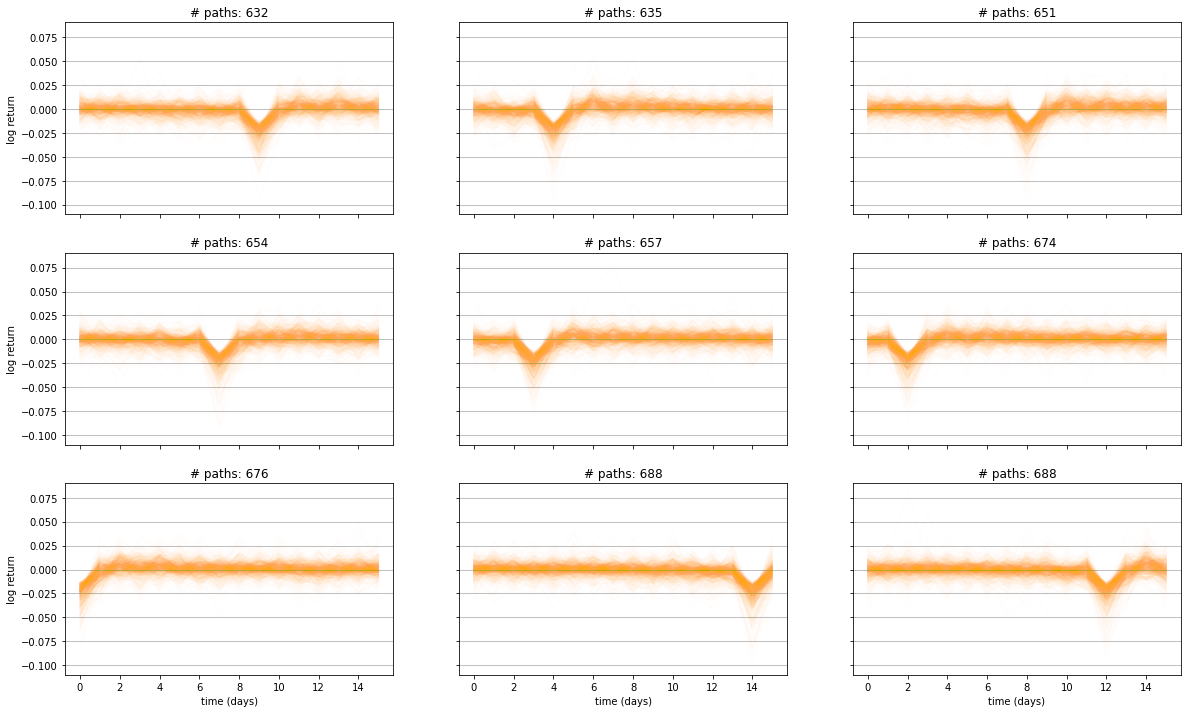

In [16]:
small_bins = np.argsort(total_freq[:, 1])[:9]
fig, ax = plot_clustering(synth_samples, synth_bins, 0.01, small_bins, (20, 12));

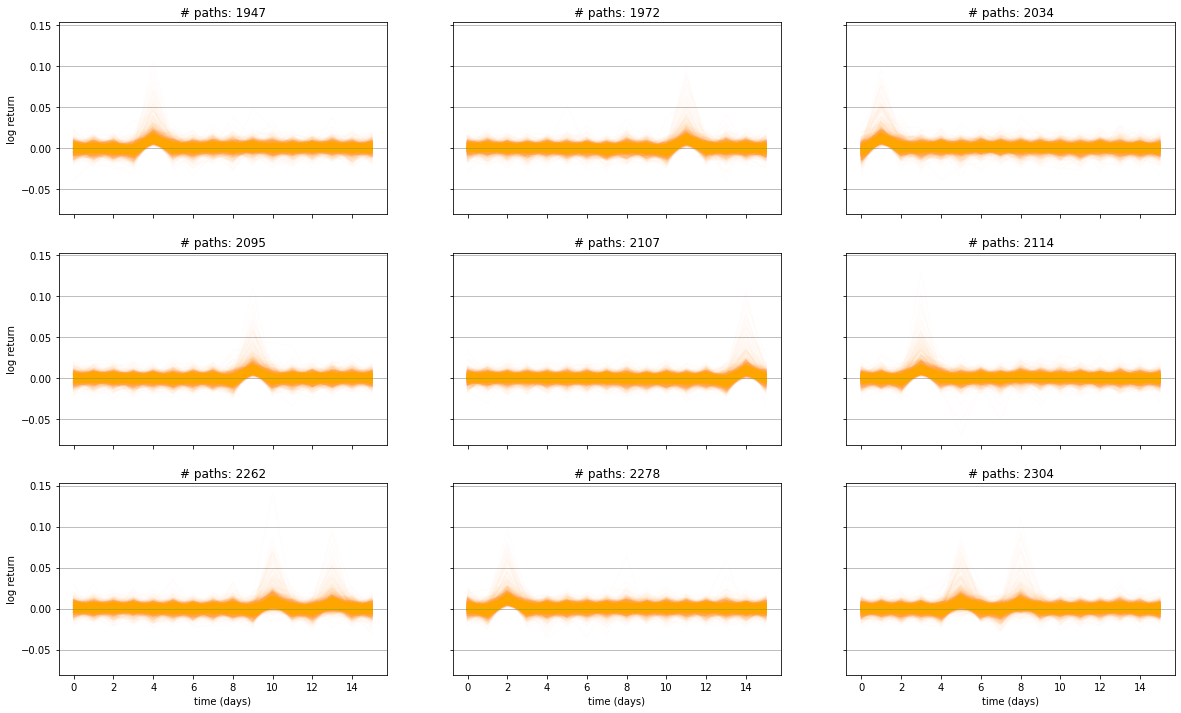

In [17]:
big_bins = np.argsort(total_freq[:, 1])[-9:]
fig, ax = plot_clustering(synth_samples, synth_bins, 0.01, big_bins, (20, 12));

In [18]:
real_samples, synth_samples, real_bins, synth_bins, total_freq, kmeans = clustering(log_returns, y.T, 127, 30)

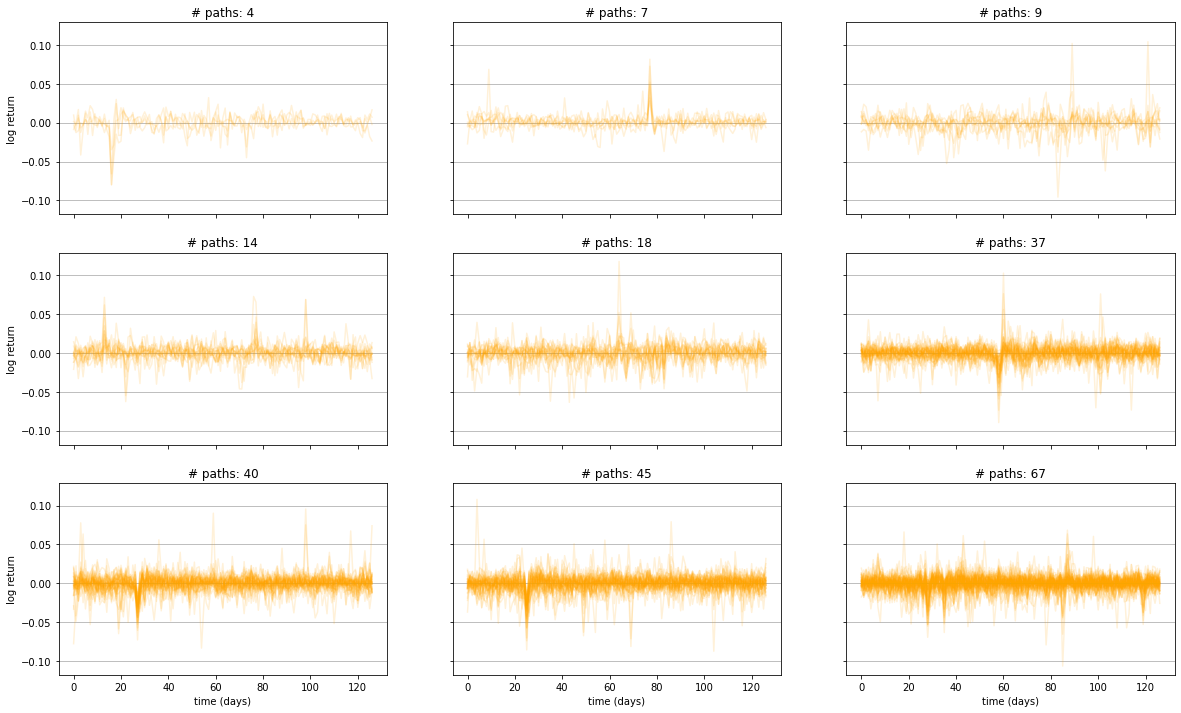

In [19]:
small_bins = np.argsort(total_freq[:, 1])[:9]
fig, ax = plot_clustering(synth_samples, synth_bins, 0.15, small_bins, (20, 12));

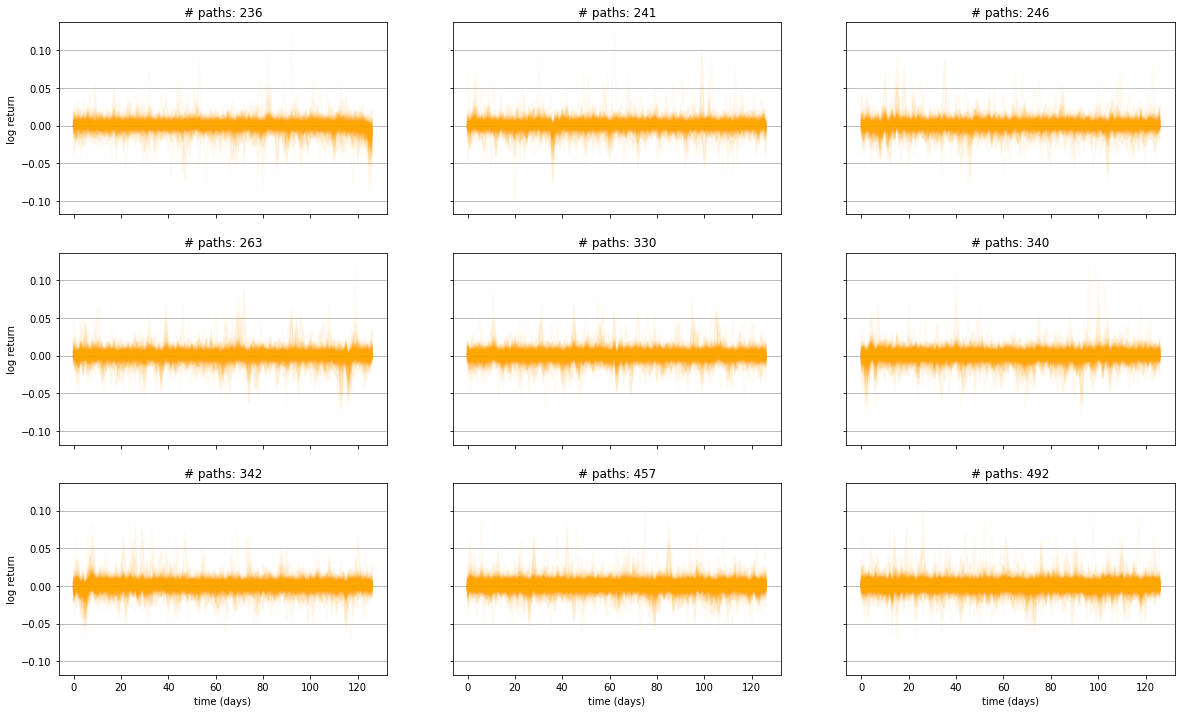

In [20]:
big_bins = np.argsort(total_freq[:, 1])[-9:]
fig, ax = plot_clustering(synth_samples, synth_bins, 0.05, big_bins, (20, 12));